# Optimal Control

In [1]:
import os
import time
import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal
import matplotlib.pyplot as plt
from casadi import (
    MX, DM, Function, Opti, integrator,
    vec, vcat, vertcat, horzcat, 
    sum1, sum2, sumsqr, sin, cos,
    gradient, jacobian, hessian
)

import casadi
casadi.__version__

'3.6.4'

In [2]:
plot_dir = 'plots'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

## Cart-pole System

In [3]:
# Physical constants
g = 9.81     # gravitation [m/s^2]
L = 0.2      # pendulum length [m]
m = 1        # pendulum mass [kg]
mcart = 0.5  # cart mass [kg]

T = 2.0  # control horizon [s]
N = 160  # Number of control intervals

dt = T/N  # length of 1 control interval [s]

# System is composed of 4 states
nx = 4

In [4]:
speedup = 4  # 0..4

In [5]:
# CasADi function for the ODE right-hand side
xk = MX.sym('x',nx) # states: pos [m], theta [rad], dpos [m/s], dtheta [rad/s]
uk = MX.sym('u') # control force [N]
ddpos = (
    (uk + m * L * xk[3] * xk[3] * sin(xk[1]) - m * g * sin(xk[1]) * cos(xk[1]))
    / (mcart + m - m * cos(xk[1]) * cos(xk[1]))
)
rhs = vertcat(xk[2], xk[3], ddpos, g/L * sin(xk[1]) - cos(xk[1]) * ddpos)

# Continuous-time system dynamics
f = Function('f', [xk, uk], [rhs], ['xk', 'uk'], ['dxdt'])
f

Function(f:(xk[4],uk)->(dxdt[4]) MXFunction)

In [6]:
# Discrete-time system dynamics
intg_options = {'number_of_finite_elements': 1}
if speedup >= 3:
    intg_options['simplify'] = 1

# Reference Runge-Kutta implementation
solver = 'rk'
dae = {'x': xk, 'p': uk, 'ode': f(xk, uk)}
t0 = 0
tf = dt / intg_options['number_of_finite_elements']
intg = integrator('intg', solver, dae, t0, tf, intg_options)
print(intg)
res = intg(x0=xk, p=uk)
xf = res['xf']

# Discretized system dynamics
F = Function('F', [xk, uk], [xf], ['xk', 'uk'], ['xkp1'])
F

intg:(x0[4],z0[0],p,u[0],adj_xf[],adj_zf[],adj_qf[])->(xf[4],zf[],qf[0],adj_x0[],adj_z0[],adj_p[],adj_u[]) MXFunction


Function(F:(xk[4],uk)->(xkp1[4]) MXFunction)

## Define optimal control problem using multiple shooting

$$
\DeclareMathOperator * {\minimize}{minimize}
\begin{aligned}
\minimize_{x_1,x_2,...,x_{N+1},u_1,u_2,...,u_N} \quad & \sum_{k=1}^{N}{u_k^2} + \phi \sum_{k=1}^{N+1}{x_k^2} \\
\text{subject to} \quad & F(x_k,u_k) = x_{k+1}, \quad k=1, ..., N \\
                  & -3 \le x_k \le 3, \quad k=1, ..., N+1 \\
                  & -1.2 \le u_k \le 1.2, \quad k=1, ..., N \\
                  & x_1 = x_\text{init} \\
                  & x_{N+1} = \left[\begin{matrix}0 & 0 & 0 & 0\end{matrix}\right]^T \\
\end{aligned}
$$


In [7]:
opti = Opti()

# Decision variables for states
X = opti.variable(nx, N + 1)

# Aliases for states
pos    = X[0, :]
theta  = X[1, :]
dpos   = X[2, :]
dtheta = X[3, :]

# Decision variables for control vector
U =  opti.variable(N, 1)  # force [N]

# 1.2: Parameter for initial state
x0 = opti.parameter(nx)

# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[:, k+1] == F(X[:, k], U[k]))

# Path constraints
opti.subject_to(opti.bounded(-3, pos, 3))
opti.subject_to(opti.bounded(-1.2, U, 1.2))

# Initial and terminal constraints
opti.subject_to(X[:, 0] == x0)
opti.subject_to(X[:, -1] == vertcat(0, 0, 0, 0))

# Objective: regularization of controls
# 1.1: added regularization
opti.minimize(sumsqr(U) + 1000 * sumsqr(pos))

## Solve optimization problem

In [8]:
options = {'print_time': False}

if speedup >= 3:
    options['expand'] = True  # expand makes function evaluations faster but requires more memory

if speedup >= 2:
    options['qpsol'] = 'qrqp';
    options['qpsol_options'] = {'print_iter': False, 'print_header': False}
    options['print_iteration'] = False
    options['print_header'] = False
    options['print_status'] = False
    opti.solver('sqpmethod', options)
else:
    options['ipopt'] = {'print_level': 0}
    opti.solver('ipopt', options)

opti.set_value(x0, vertcat(0.5, 0, 0, 0))

sol = opti.solve()
sol

OptiSol(Opti {
  instance #0
  #variables: 2 (nx = 804)
  #parameters: 1 (np = 4)
  #constraints: 164 (ng = 969)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
})

## MPC loop

In [9]:
current_x = vertcat(0.5, 0, 0, 0)

x_history = DM.zeros(nx, 400)
u_history = DM.zeros(1, 400)

np.random.seed(0)

print('MPC running')

if speedup < 4:
  
    for i in range(400):
        t0 = time.time()
        # What control signal should I apply?
        u_sol = sol.value(U[0])

        u_history[:,i] = u_sol

        # Simulate the system over dt
        current_x = F(current_x,u_sol)
        if i > 200:
          current_x = current_x + vertcat([0, 0, 0, 0.01 * np.random.rand()])

        if speedup >= 1:
            # Set the initial values to the previous results
            opti.set_initial(opti.x, sol.value(opti.x)) # decision variables
            opti.set_initial(opti.lam_g, sol.value(opti.lam_g)) # multipliers

        # Set the value of parameter x0 to the current x
        opti.set_value(x0, current_x)

        # Solve the NLP
        sol = opti.solve()

        x_history[:,i] = current_x
        print(f"{i:03d}: {time.time() - t0:.5f}")

if speedup >= 4:
    inputs = [x0, opti.x, opti.lam_g]
    outputs = [U[0], opti.x, opti.lam_g]
    mpc_step = opti.to_function('mpc_step', inputs, outputs)
    print(mpc_step)
    
    u = sol.value(U[0])
    x = sol.value(opti.x)
    lam = sol.value(opti.lam_g)
    
    for i in range(400):
        t0 = time.time()
        u_history[:, i] = u
        
        # Simulate the system over dt
        current_x = F(current_x, u)
        if i > 200:
          current_x = current_x + vertcat([0, 0, 0, 0.01 * np.random.rand()])
        
        u, x, lam = mpc_step(current_x, x, lam)

        x_history[:, i] = current_x
        print(f"{i:03d}: {time.time() - t0:.5f}")


MPC running
mpc_step:(i0[4],i1[804],i2[969])->(o0,o1[804],o2[969]) MXFunction
000: 0.00733
001: 0.00811
002: 0.00761
003: 0.00706
004: 0.00721
005: 0.00702
006: 0.00837
007: 0.00985
008: 0.00862
009: 0.00739
010: 0.00733
011: 0.00683
012: 0.00648
013: 0.00648
014: 0.00645
015: 0.00643
016: 0.00642
017: 0.00642
018: 0.00701
019: 0.00658
020: 0.00728
021: 0.00690
022: 0.00691
023: 0.00653
024: 0.00684
025: 0.00758
026: 0.00790
027: 0.00716
028: 0.00698
029: 0.00704
030: 0.00714
031: 0.00825
032: 0.00865
033: 0.00852
034: 0.00709
035: 0.00775
036: 0.00670
037: 0.00816
038: 0.00703
039: 0.00709
040: 0.00762
041: 0.00768
042: 0.00688
043: 0.00714
044: 0.00924
045: 0.01351
046: 0.00801
047: 0.00741
048: 0.01155
049: 0.01079
050: 0.00706
051: 0.00778
052: 0.00724
053: 0.00719
054: 0.00734
055: 0.00714
056: 0.00641
057: 0.01127
058: 0.00886
059: 0.00836
060: 0.00689
061: 0.00706
062: 0.00658
063: 0.00621
064: 0.00793
065: 0.00606
066: 0.00751
067: 0.00733
068: 0.00651
069: 0.00689
070: 0.00614

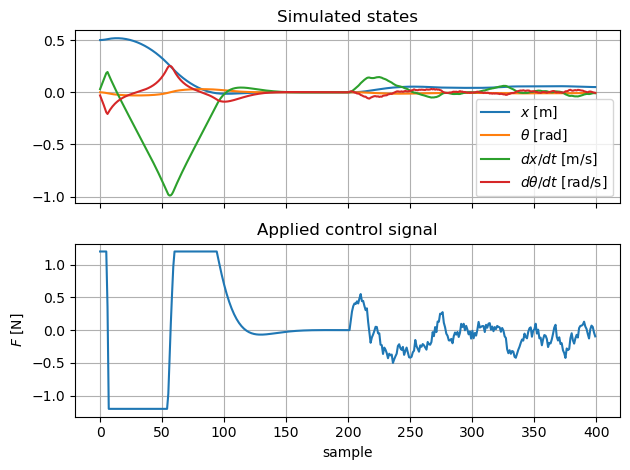

In [10]:
fig, axes = plt.subplots(2, 1, sharex=True)

x_labels = [r'$x$ [m]', r'$\theta$ [rad]', r'$dx/dt$ [m/s]', r'$d\theta/dt$ [rad/s]']
u_label = r'$F$ [N]'

ax = axes[0]
ax.plot(x_history.T)
ax.grid()
ax.set_title('Simulated states')
ax.legend(x_labels)

ax = axes[1]
ax.plot(u_history.T)
ax.set_xlabel('sample')
ax.set_ylabel(u_label)
ax.grid()
ax.set_title('Applied control signal')

plt.tight_layout()
filename = 'mpc_solution.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()